# Maximum likelihood with $C_\text{IMA}$

In [1]:
import jax
from jax import numpy as jnp
import numpy as np
import distrax
import haiku as hk
from residual import TriangularResidual, spectral_norm_init, spectral_normalization, masks_triangular_weights, make_weights_triangular, LipSwish

from jax.experimental.optimizers import adam

In [2]:
key = jax.random.PRNGKey(1)

## Generate data

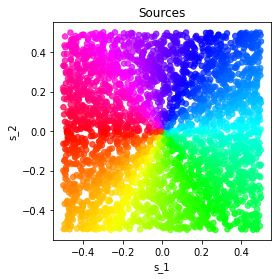

In [3]:
# N:=Number of samples
N = 3000
# D:=Number of dimensions
D = 2

# Generate the samples
S = jax.random.uniform(key, shape=(N, D), minval=0.0, maxval=1.0)

S -= 0.5


from plotting import cart2pol, scatterplot_variables

_, colors = cart2pol( S[:,0], S[:,1])

# Plot the sources
scatterplot_variables(S, 'Sources', colors=colors, savefig=False)

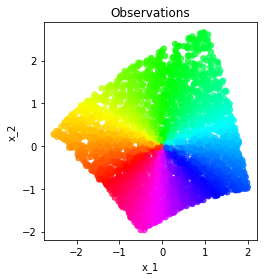

In [4]:
# from mixing_functions import build_conformal_map
# nonlinearity = lambda x : jnp.exp(1.3*x)
# mixing, mixing_gridplot = build_conformal_map(nonlinearity)

from mixing_functions import build_moebius_transform

# Generate a random orthogonal matrix
from scipy.stats import ortho_group # Requires version 0.18 of scipy

A = ortho_group.rvs(dim=D)

# Scalar
alpha = 2.0
# Two vectors with data dimensionality
a = np.array([1.5, -3.5]) #2.0 * np.ones(D) # a vector in \RR^D
b = 3.0 * np.ones(D) # a vector in \RR^D

from jax import vmap
mixing_moebius, _ = build_moebius_transform(alpha, A, a, b, epsilon=2)
mixing_batched = vmap(mixing_moebius)

from jax import vmap

mixing_batched = vmap(mixing_moebius)

X = mixing_batched(S)
X -= jnp.mean(X, axis=0)
X /= jnp.std(X, axis=0)

scatterplot_variables(X, 'Observations', colors=colors, savefig=False)#True, fname="observations_flow")

## Set up model

In [5]:
n_layers = 5 #32
hidden_units = [20, 20] #[128, 128]

# I would substitute the Normal with a Logistic distribution

def log_prob(x):
    base_dist = distrax.Independent(distrax.Logistic(loc=jnp.zeros(2), scale=jnp.ones(2)),
                                                    reinterpreted_batch_ndims=1)
    flows = distrax.Chain([TriangularResidual(hidden_units + [2], name='residual_' + str(i))
                           for i in range(n_layers)])
    model = distrax.Transformed(base_dist, flows)
    return model.log_prob(x)

In [6]:
# Init model
logp = hk.transform(log_prob)
params = logp.init(key, jnp.array(np.random.randn(5, 2)))

In [7]:
# In ML + C_IMA, we don't want triangular Jacobian! I comment out the below

# # Make triangular
# masks = masks_triangular_weights([h // 2 for h in hidden_units])
# params = make_weights_triangular(params, masks)

In [8]:
# This is one part of the loss!
# Copied over from the triangular_residual_flow_test notebook

def inv_map_fn(x):
    flows = distrax.Chain([TriangularResidual(hidden_units + [2], name='residual_' + str(i))
                           for i in range(n_layers)])
    return flows.inverse(x)

inv_map = hk.transform(inv_map_fn)

def cima(x, params):
    jac_fn = jax.vmap(jax.jacfwd(lambda y: inv_map.apply(params, None, y)))
    J = jac_fn(x)
    detJ = J[:, 0, 0] * J[:, 1, 1] - J[:, 0, 1] * J[:, 1, 0]
    out = jnp.sum(jnp.log(jnp.linalg.norm(J, axis=2)), axis=1) - jnp.log(jnp.abs(detJ))
    return out

In [9]:
# Apply spectral normalization

uv = spectral_norm_init(params, key)
params, uv = spectral_normalization(params, uv)

In [10]:
# Define a Lagrange multiplier to be multiplied before the c_ima contrast
lag_mult = 1.0

def loss(params, x):
    ll = logp.apply(params, None, x)
    c_ima = cima(x, params)
    return -jnp.mean(ll) + lag_mult * jnp.mean(c_ima)

Model training

In [11]:
opt_init, opt_update, get_params = adam(step_size=1e-3)

@jax.jit
def step(it, opt_state, uv, x):
    params = get_params(opt_state)
#     params = make_weights_triangular(params, masks) # makes Jacobian triangular
    params, uv = spectral_normalization(params, uv)
    params_flat = jax.tree_util.tree_flatten(params)[0]
    for ind in range(len(params_flat)):
        opt_state.packed_state[ind][0] = params_flat[ind]
    value, grads = jax.value_and_grad(loss, 0)(params, x)
    opt_out = opt_update(it, grads, opt_state)
    return value, opt_out, uv

In [12]:
iters, batch_size = 50000, 256

opt_state = opt_init(params)

loss_hist = np.array([])

In [ ]:
for i in range(iters):
    x = X[np.random.choice(X.shape[0], batch_size)]
    value, opt_state, uv = step(i, opt_state, uv, x)
    loss_hist = np.append(loss_hist, value.item())
    if i%2000==0:
        print("iter=", i, "; loss=", value.item())

iter= 0 ; loss= 3.251516342163086
iter= 2000 ; loss= 2.707127094268799
iter= 4000 ; loss= 2.5921859741210938
iter= 6000 ; loss= 2.530522584915161
iter= 8000 ; loss= 2.523084878921509
iter= 10000 ; loss= 2.513777494430542
iter= 12000 ; loss= 2.5235984325408936
iter= 14000 ; loss= 2.5186967849731445
iter= 16000 ; loss= 2.513526678085327
iter= 18000 ; loss= 2.5183746814727783
iter= 20000 ; loss= 2.4581286907196045
iter= 22000 ; loss= 2.4494640827178955
iter= 24000 ; loss= 2.474193572998047
iter= 26000 ; loss= 2.4843592643737793
iter= 28000 ; loss= 2.495734453201294
iter= 30000 ; loss= 2.5016303062438965


In [ ]:
params_final = get_params(opt_state)
# params_final = make_weights_triangular(params_final, masks)
params_final, _ = spectral_normalization(params_final, uv)

In [ ]:
from matplotlib import pyplot as plt

plt.plot(loss_hist)

In [ ]:
def inv_map_fn(x):
    flows = distrax.Chain([TriangularResidual(hidden_units + [2], name='residual_' + str(i))
                           for i in range(n_layers)])
    return flows.inverse(x)
inv_map = hk.transform(inv_map_fn)

In [ ]:
S_rec = inv_map.apply(params_final, None, X)

In [ ]:
scatterplot_variables(S_rec, 'Sources', colors=colors, savefig=False)

In [ ]:
from jax.scipy.stats import logistic

In [ ]:
S_unif = logistic.cdf(S_rec) # use the Logistic cdf here!

In [ ]:
scatterplot_variables(S_unif, 'Sources', colors=colors, savefig=False)

In [ ]:
scatterplot_variables(S, 'Sources', colors=colors, savefig=False)

## Compute CIMA

In [ ]:
def cima(x):
    jac_fn = jax.vmap(jax.jacfwd(lambda y: inv_map.apply(params_final, None, y)))
    J = jac_fn(x)
    detJ = J[:, 0, 0] * J[:, 1, 1] - J[:, 0, 1] * J[:, 1, 0]
    out = jnp.sum(jnp.log(jnp.linalg.norm(J, axis=2)), axis=1) - jnp.log(jnp.abs(detJ))
    return out

In [ ]:
c = cima(X)

In [ ]:
jnp.mean(c)

In [ ]:
# Check that the Jacobian is **not** triangular
jac_fn = jax.vmap(jax.jacfwd(lambda y: inv_map.apply(params_final, None, y)))
J = jac_fn(X)
# J.shape
mean_J = np.mean(J, axis=0)
# mean_J.shape
print(mean_J)

In [ ]:
# Use the Amari distance for evaluation